In [5]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

# 03. 케글 탐구하기

- 참여 대회 :  https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr

__목차__
1. 평가 기준 살펴보기
1. 일단 제출하기
1. 랭킹올리기-> 최적의 모델찾기, 하이퍼 파라미터 튜닝
1. 프로젝트: This is your playground! Leaderboard를 정복해주세요

__필수 라이브러리 설치__

In [1]:
!conda list | grep xgboost
!conda list | grep lightgbm
!conda list | grep missingno
!pip list | grep scikit-learn

xgboost                   1.4.2                    pypi_0    pypi
lightgbm                  3.3.0                    pypi_0    pypi
missingno                 0.5.0                    pypi_0    pypi
scikit-learn                  1.0


In [2]:
!mkdir -p ~/aiffel/kaggle_kakr_housing

## 사전 준비
1. 평가기준 살펴보기
1. 대회규칙 숙지하기
1. 데이터 설명 꼼꼼히 읽고 이해하기
1. 데이터 파일 유형 살펴보기

__RMSE 수식(평가방식)__
$${\sqrt{ {1 \over N} \sum{(yt - y{pr})}^2}} $$

### 데이터 준비 
- 클라우드 상에서는 따로 경로를 지정
- 단, 로컬에서는 케글에서 다운로드 해야함
- 현재 로컬 환경에서는 미리 다운로드하여 준비했음 (data 폴더에 넣어놓음)

In [3]:
# 클라우드에 있는 데이터 결로
!mkdir -p ~/aiffel/kaggle_kakr_housing/data
!ln -s ~/data/data/*.csv ~/aiffel/kaggle_kakr_housing/data
!ls ~/aiffel/kaggle_kakr_housing/data  # 디렉토리 내 파일 확인

sample_submission.csv  test.csv  train.csv


In [6]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [7]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


## Baseline 모델 세팅하기

- baseline 모델은 기본적으로 문제 해결을 시작할 때 쉽게 사용할 수 있는 샘플
- 교육적인 성격이 강한 대회같은 경우 제공하는 경우가 많이 있음

### 결측치 확인하는 인덱싱

In [10]:
# 널값 체크
null_check = pd.isnull(data["id"])
print(null_check)

0        False
1        False
2        False
3        False
4        False
         ...  
15030    False
15031    False
15032    False
15033    False
15034    False
Name: id, Length: 15035, dtype: bool


In [13]:
# 널값 체크 2
null_data = data.loc[null_check, "id"]
null_data.head()

Series([], Name: id, dtype: int64)

In [18]:
# 결측치 데이터 개수를 셉니다
print(f"id : {len(null_data.values)}")

id : 0


In [20]:
a = len(data.loc[null_check, "id"].values)
print(f"id : {a}")

id : 0


In [22]:
for c in data.columns:
#     a = len(data.loc[null_check, c].values)
    print(f"{c} : {len(data.loc[null_check, c].values)}")

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [26]:
data['id']

0            0
1            1
2            2
3            3
4            4
         ...  
15030    15030
15031    15031
15032    15032
15033    15033
15034    15034
Name: id, Length: 15035, dtype: int64

In [29]:
data['id'][15035:]

Series([], Name: id, dtype: int64)

### seaborn

- subplots로 객체를 선언하면 도화지와 생선된 그래프 축들이 생긴다.
- 그걸 두 개로 받아서 각각 활용할 수 있다. 


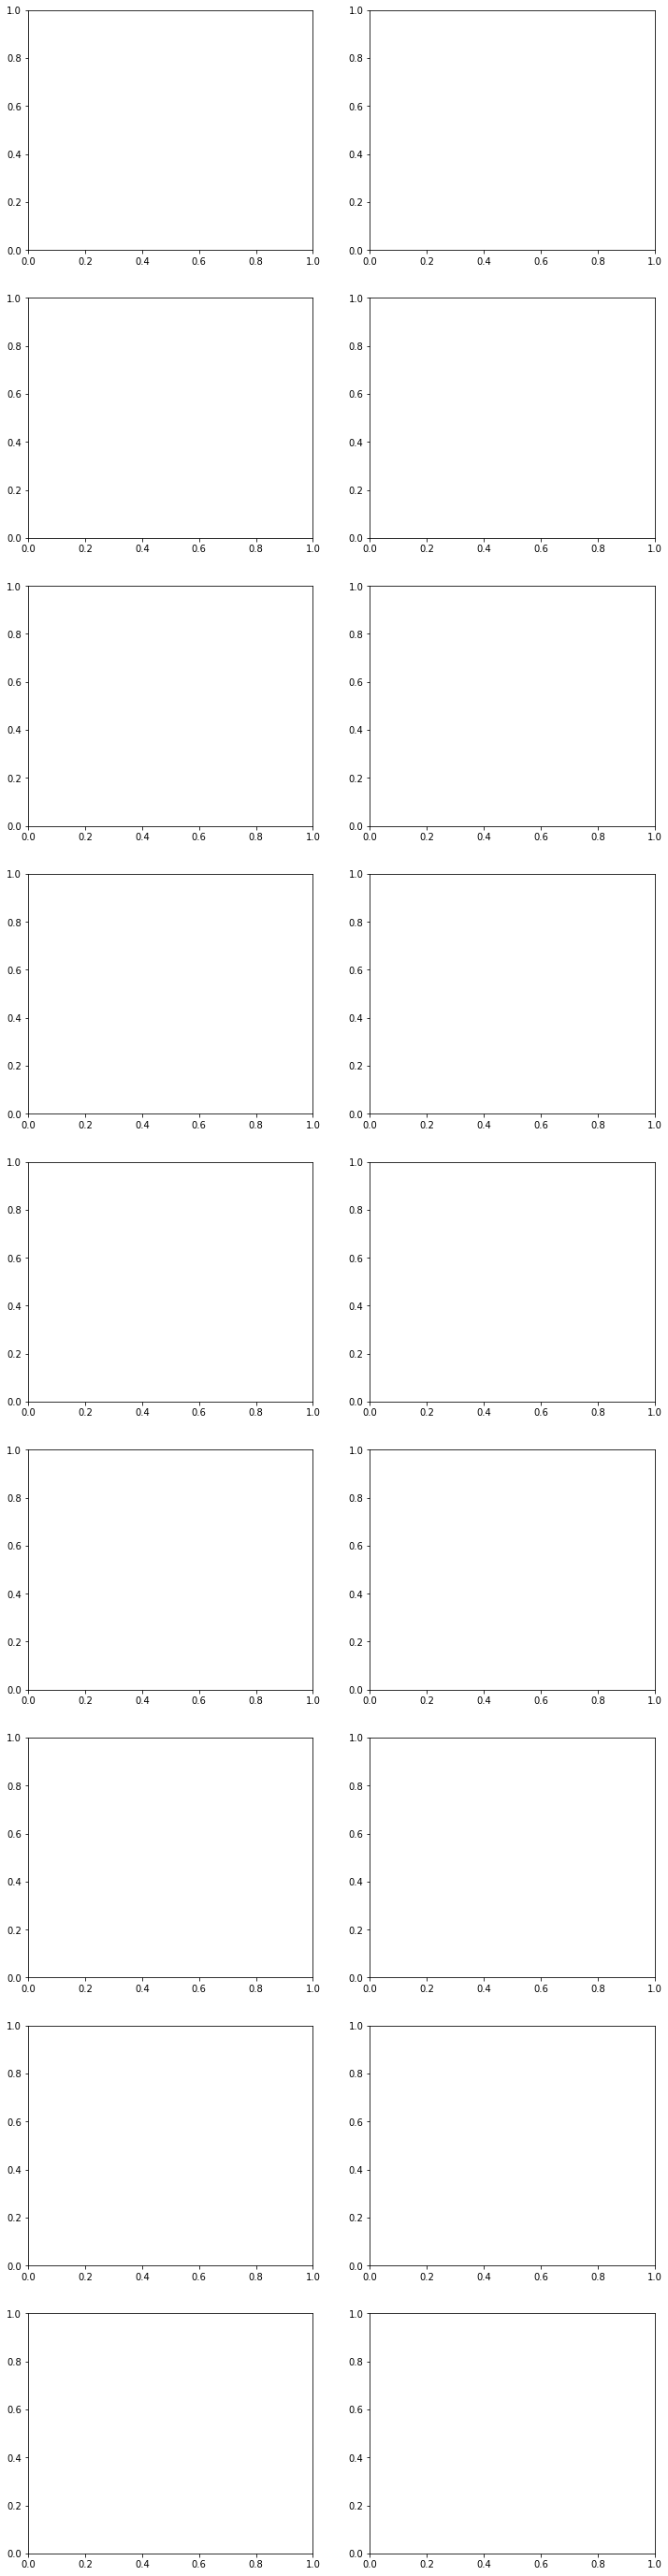

In [30]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

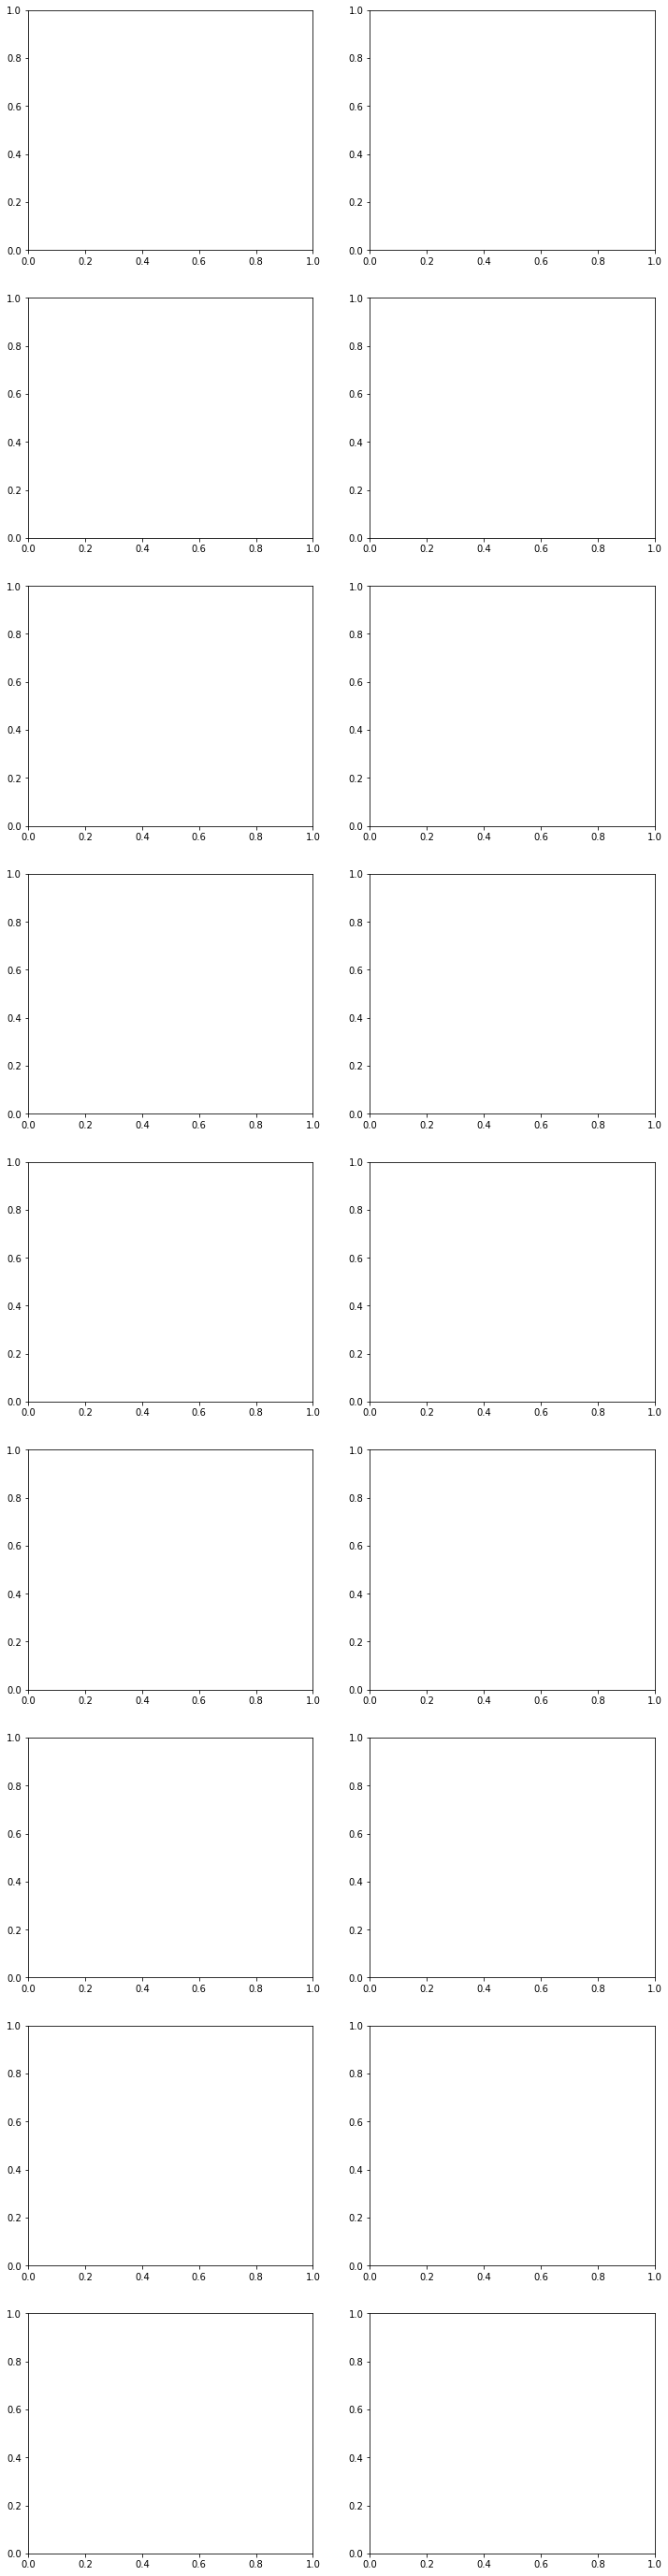

In [32]:
fig

In [36]:
ax[0]

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

(<Figure size 864x3600 with 18 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>]], dtype=object))

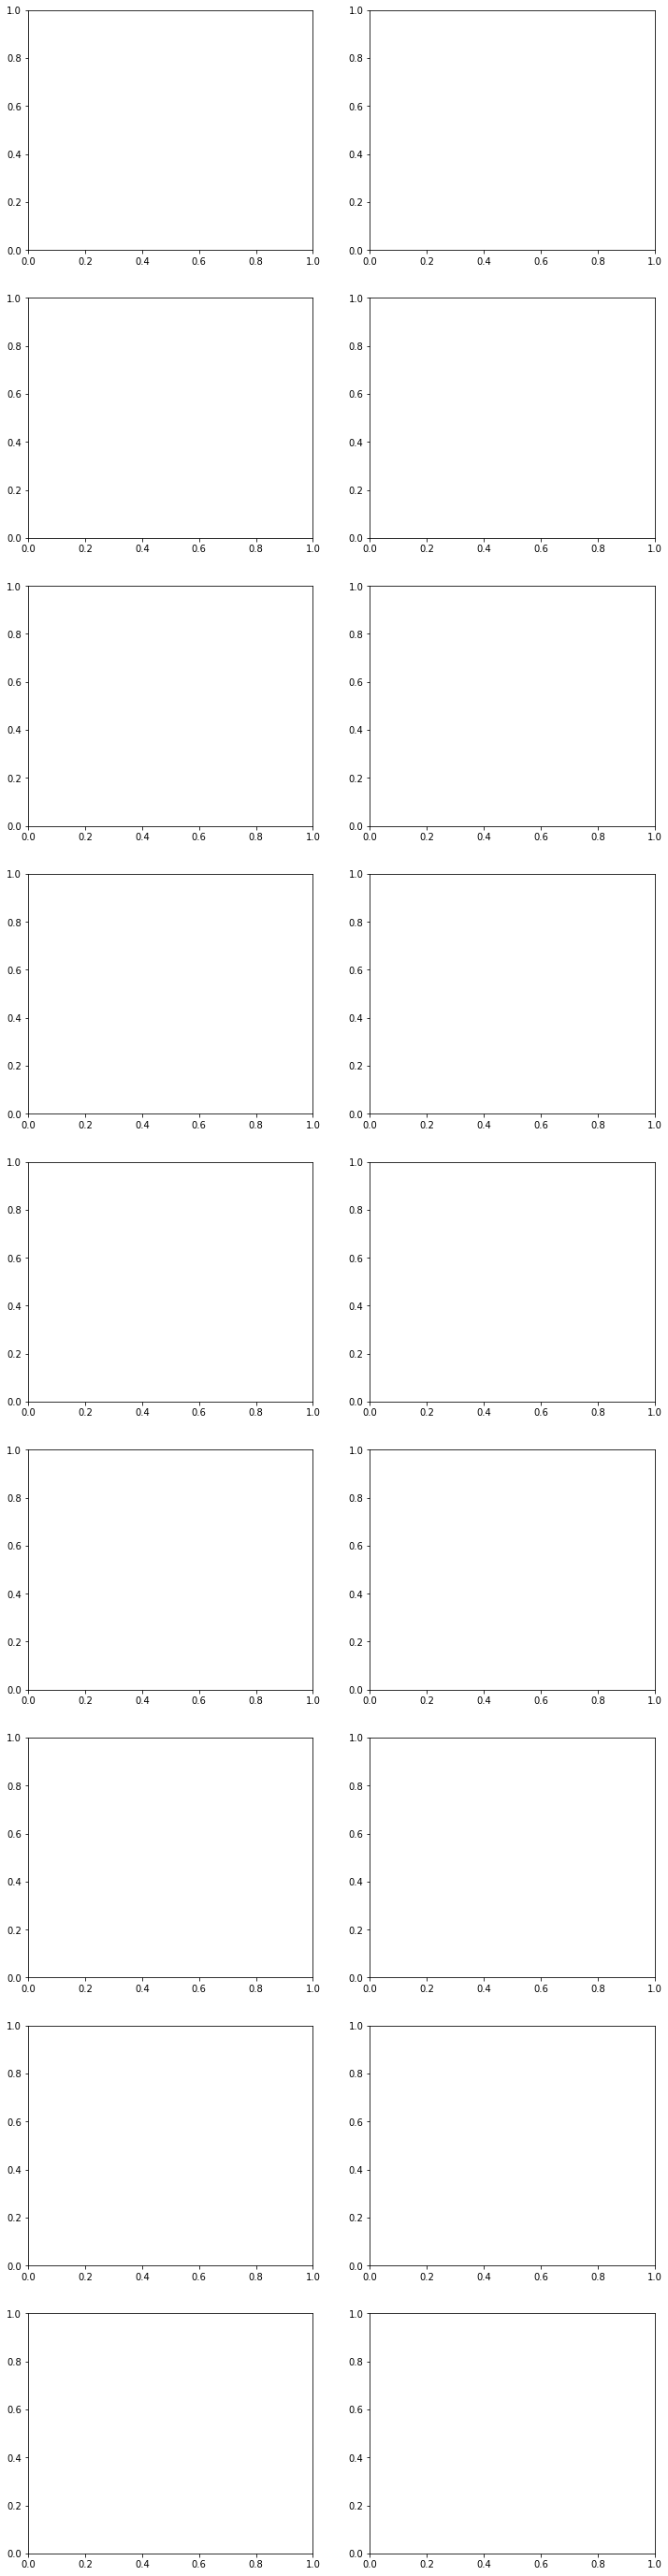

In [31]:
plt.subplots(9, 2, figsize=(12, 50))

### log함수는 왜 분포의 치우침을 줄어들게 만드는가?

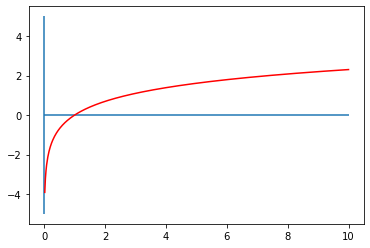

In [37]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

- 작은 수는 급격히 크게 만들어 주고 큰 수는 작게 만들어 준다
- 0에 가깝게 모여있는 값들이 x로 입력되면, y값이 매우 넓게 퍼진다.
- 반면, x값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아진다. 
- 큰 값들에 대해서 y값이 크게 차이나지 않게 된다는 뜻. 
- 따라서 넓은 범위를 가진 x값을 y값의 구간 내에 모이게 하는 특징을 가짐

#### 1. 앙상블 기법 중 가장 기본적인 것은 보팅(Voting)과 에버리징(Averaging)입니다. 각각 무엇이고, 언제 쓰이나요.

- 이 둘은 모두 서로 다른 알고리즘을 가진 분류기를 결합하는 방식입니다. 
- Voting은 여러 모델이 분류해 낸 결과들로부터 말 그래로 다수결 투표를 통해 최종 결과를 선택하는 방법으로, 분류 문제에서 사용됩니다. 
- 반면, Averaging은 각 모델이 계산해 낸 실숫값들을 평균 혹은 가중평균하여 사용하는 방법으로,  

- 참고자료 : https://jamm-notnull.tistory.com/16

### $R^2$ 결정계수란?
>참고자료 : https://ltlkodae.tistory.com/19
- 회귀모델이 주어진 자료에 얼마나 적합한지를 평가하는 지표
- y의 변동량대비 모델 예측값의 변동량을 의미한
- 0~1의 값을 가지며, 상관관계가 높을수록 1에 가까워짐
- r2=0.3인 경우 약 30% 정도의 설명력을 가진다라고 해석할 수 있음
- sklearn의 r2_score의 경우 데이터가 arbitrarily할 경우 음수가 나올 수 있음
- 음수가 나올경우 모두 일괄 평균으로 예측하는 것보다 모델의 성능이 떨어진다는 의미
- 결정계수는 독립변수가 많아질 수록 값이 커지기 때문에, 독립변수가 2개 이상일 경우 조정된 결정계수를 사용해야함

### np.column_stack
> 공식문서 ; https://numpy.org/doc/stable/reference/generated/numpy.column_stack.html


